## Pipeline de segmentação por cor (vermelho)

**Objetivo:** isolar a região vermelha da imagem mantendo a cor original.

### Etapas
1. Ler a imagem
2. Preparar para OpenCV (BGR)
3. Converter para HSV
4. Visualizar canais H, S, V *(análise exploratória)*
5. Criar máscara do vermelho
6. Refinar a máscara (morfologia)
7. Aplicar máscara na imagem original
8. Comparar resultados



In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
img_path = "/content/PapaiNoel.jpeg" # Leitura da imagem
img_bgr = cv2.imread(img_path)       # para processamento no OpenCV

Conversão da imagem para o espaço HSV

In [3]:
img_hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)


A imagem em HSV não é visualmente interpretável diretamente.
A visualização correta é feita canal a canal.

(np.float64(-0.5), np.float64(719.5), np.float64(1279.5), np.float64(-0.5))

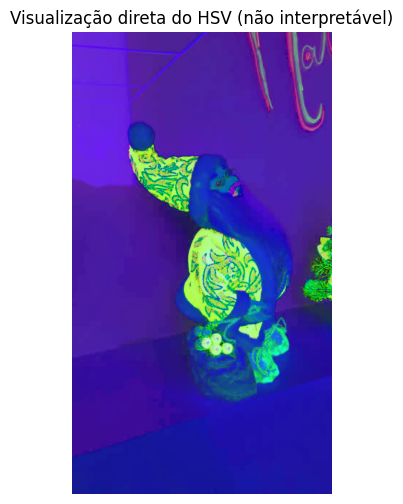

In [4]:
plt.figure(figsize=(6,6))
plt.imshow(img_hsv)
plt.title("Visualização direta do HSV (não interpretável)")
plt.axis("off")

## Visualização dos canais HSV (análise exploratória)

Esta etapa auxilia a responder empiricamente:

**(a) Onde está o vermelho no canal H?**  
Forma uma faixa contínua? Está próximo de 0° ou 180°? Vaza para laranja?

**(b) O vermelho é saturado?**  
Roupa → saturação alta  
Sombras/reflexos → saturação reduzida

**(c) O vermelho é claro ou escuro?**  
Partes iluminadas → V alto  
Dobras e sombras → V baixo


(np.float64(-0.5), np.float64(719.5), np.float64(1279.5), np.float64(-0.5))

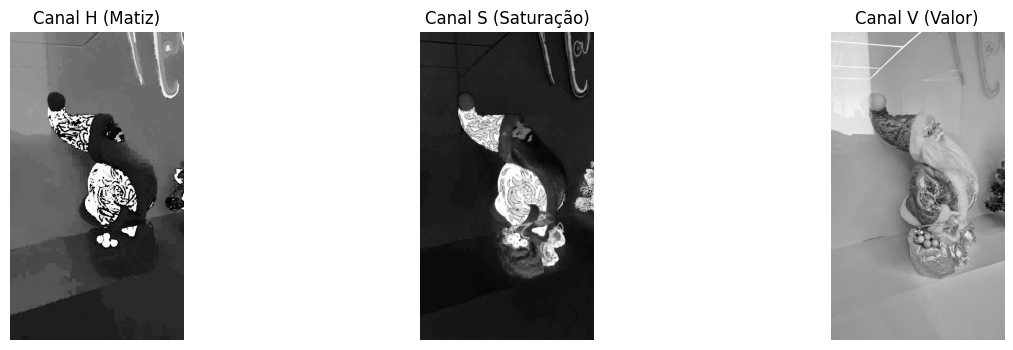

In [5]:
h, s, v = cv2.split(img_hsv)

plt.figure(figsize=(15,4))

plt.subplot(1,3,1)
plt.imshow(h, cmap="gray")
plt.title("Canal H (Matiz)")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(s, cmap="gray")
plt.title("Canal S (Saturação)")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(v, cmap="gray")
plt.title("Canal V (Valor)")
plt.axis("off")


Para segmentar a cor vermelha no HSV é necessário criar duas máscaras.
O vermelho é o único caso problemático, pois o espaço HSV é circular e
o OpenCV “corta” o círculo justamente na região do vermelho.


(np.float64(-0.5), np.float64(719.5), np.float64(1279.5), np.float64(-0.5))

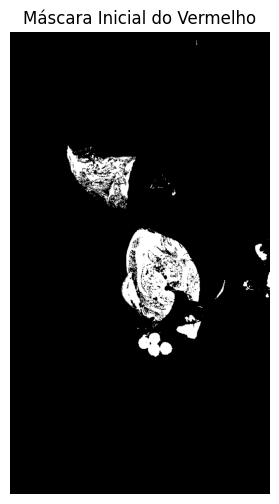

In [6]:
# Faixa 1 do vermelho
lower_red1 = np.array([0, 120, 70])
upper_red1 = np.array([10, 255, 255])

# Faixa 2 do vermelho
lower_red2 = np.array([170, 120, 70])
upper_red2 = np.array([180, 255, 255])

mask1 = cv2.inRange(img_hsv, lower_red1, upper_red1)
mask2 = cv2.inRange(img_hsv, lower_red2, upper_red2)

mask_red = mask1 + mask2

plt.figure(figsize=(6,6))
plt.imshow(mask_red, cmap="gray")
plt.title("Máscara Inicial do Vermelho")
plt.axis("off")


## Refinamento da máscara (morfologia)

Define-se um elemento estruturante e aplica-se a operação OPEN
(erosão → dilatação) para remover ruídos e pequenos artefatos.


(np.float64(-0.5), np.float64(719.5), np.float64(1279.5), np.float64(-0.5))

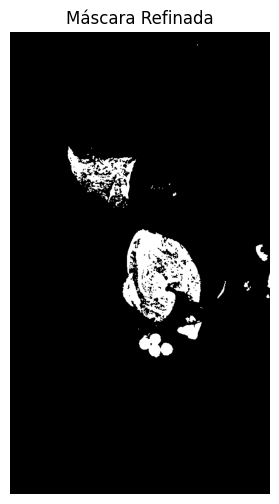

In [7]:
k = 2
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (k, k))

mask_clean = cv2.morphologyEx(mask_red, cv2.MORPH_OPEN, kernel)
mask_clean = cv2.morphologyEx(mask_clean, cv2.MORPH_CLOSE, kernel)


plt.figure(figsize=(6,6))
plt.imshow(mask_clean, cmap="gray")
plt.title("Máscara Refinada")
plt.axis("off")


## Aplicação da máscara

A máscara é aplicada à imagem original para isolar a região vermelha.


(np.float64(-0.5), np.float64(719.5), np.float64(1279.5), np.float64(-0.5))

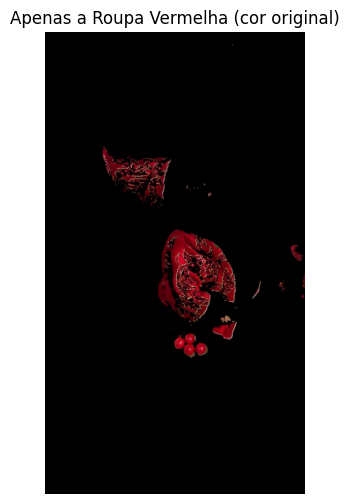

In [8]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

result = cv2.bitwise_and(img_rgb, img_rgb, mask=mask_clean)

plt.figure(figsize=(6,6))
plt.imshow(result)
plt.title("Apenas a Roupa Vermelha (cor original)")
plt.axis("off")


## Comparação: Original × HSV

Comparação entre a imagem original e o resultado da segmentação
da cor vermelha após o refinamento da máscara.


(np.float64(-0.5), np.float64(719.5), np.float64(1279.5), np.float64(-0.5))

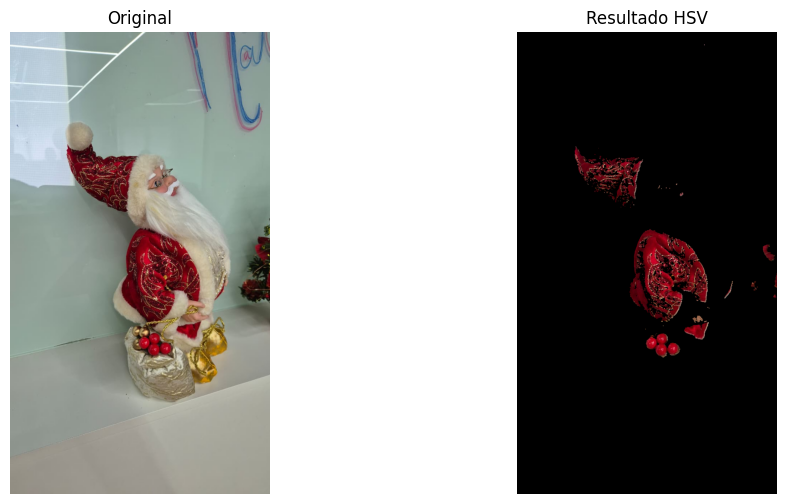

In [9]:
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.imshow(img_rgb)
plt.title("Original")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(result)
plt.title("Resultado HSV")
plt.axis("off")


## Análise no espaço de cor LAB

Nesta etapa, a imagem é convertida para o espaço LAB,
onde a informação de cor é separada da luminosidade.


(np.float64(-0.5), np.float64(719.5), np.float64(1279.5), np.float64(-0.5))

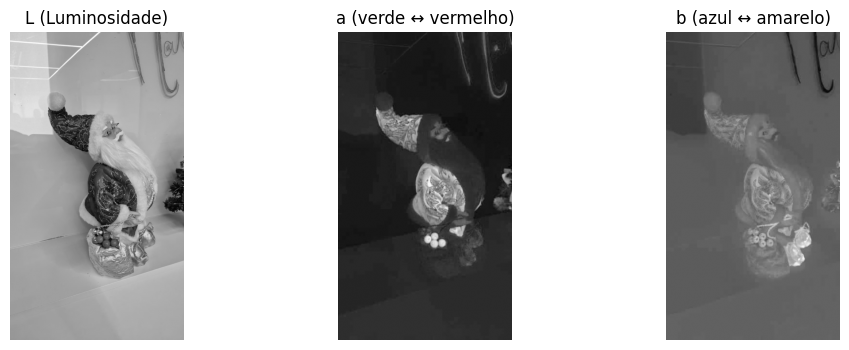

In [10]:
img_lab = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2LAB)

L, a, b = cv2.split(img_lab)

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(L, cmap="gray")
plt.title("L (Luminosidade)")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(a, cmap="gray")
plt.title("a (verde ↔ vermelho)")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(b, cmap="gray")
plt.title("b (azul ↔ amarelo)")
plt.axis("off")


A cor vermelha não depende diretamente da iluminação e
é representada por valores elevados no canal *a*.

Interpretação dos limiares:

- **L ≥ 0** → qualquer iluminação  
- **a ≥ 150** → vermelho forte  
- **b** → não utilizado nesta segmentação


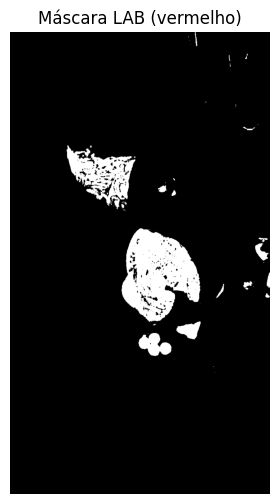

In [11]:
lower_lab = np.array([0, 150, 0])
upper_lab = np.array([255, 255, 255])

mask_lab = cv2.inRange(img_lab, lower_lab, upper_lab)

plt.figure(figsize=(6,6))
plt.imshow(mask_lab, cmap="gray")
plt.title("Máscara LAB (vermelho)")
plt.axis("off")
plt.show()


## Aplicação da máscara LAB

A máscara obtida no espaço LAB é aplicada à imagem original,
preservando a cor vermelha nas regiões segmentadas.

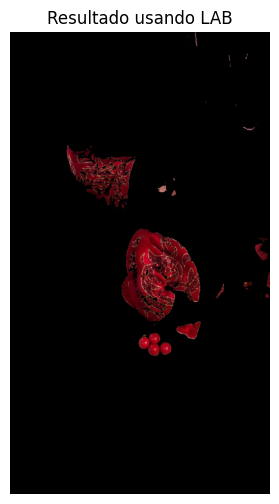

In [12]:
result_lab = cv2.bitwise_and(img_rgb, img_rgb, mask=mask_lab)

plt.figure(figsize=(6,6))
plt.imshow(result_lab)
plt.title("Resultado usando LAB")
plt.axis("off")
plt.show()

## Comparação: Original × LAB


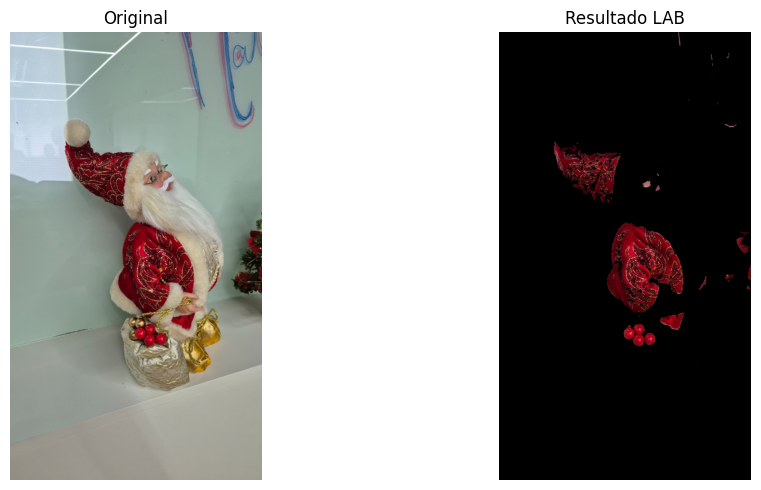

In [13]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.imshow(img_rgb)
plt.title("Original")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(result_lab)
plt.title("Resultado LAB")
plt.axis("off")

plt.tight_layout()
plt.show()


## Análise no espaço de cor YCrCb

Nesta etapa, a imagem é convertida para o espaço YCrCb,
no qual a informação de luminância é separada das componentes de cor.


(np.float64(-0.5), np.float64(719.5), np.float64(1279.5), np.float64(-0.5))

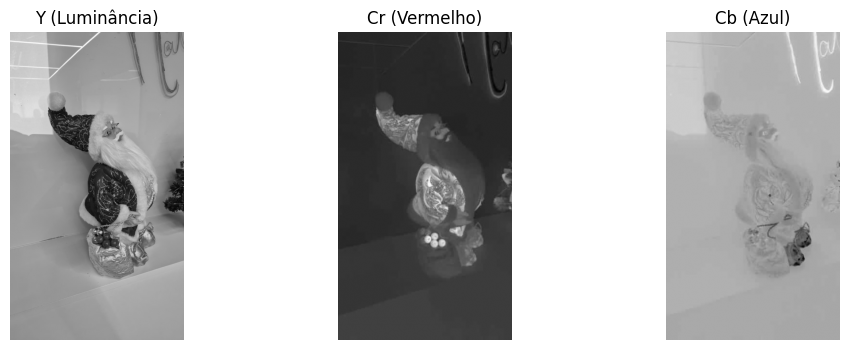

In [14]:
img_ycbcr = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2YCrCb)

Y, Cr, Cb = cv2.split(img_ycbcr)

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(Y, cmap="gray")
plt.title("Y (Luminância)")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(Cr, cmap="gray")
plt.title("Cr (Vermelho)")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(Cb, cmap="gray")
plt.title("Cb (Azul)")
plt.axis("off")


## Criação da máscara no espaço YCrCb

No espaço YCrCb, a cor vermelha é representada por valores elevados
no canal *Cr*, enquanto a luminância é tratada separadamente.


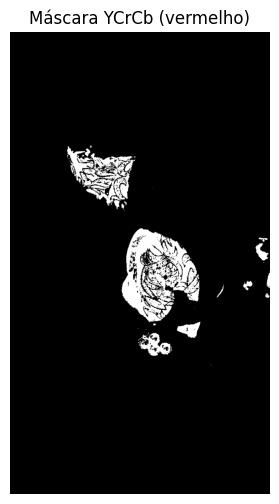

In [15]:
lower_ycbcr = np.array([0, 150, 0])
upper_ycbcr = np.array([60, 255, 255])

mask_ycbcr = cv2.inRange(img_ycbcr, lower_ycbcr, upper_ycbcr)

plt.figure(figsize=(6,6))
plt.imshow(mask_ycbcr, cmap="gray")
plt.title("Máscara YCrCb (vermelho)")
plt.axis("off")
plt.show()


## Aplicação da máscara YCrCb

A máscara obtida no espaço YCrCb é aplicada à imagem original,
preservando a cor vermelha nas regiões segmentadas.

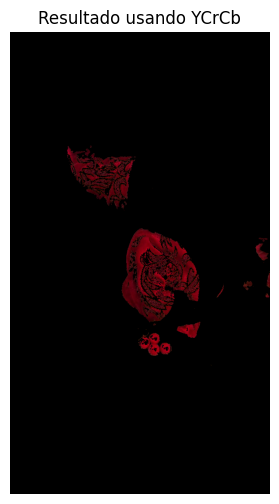

In [16]:
result_ycbcr = cv2.bitwise_and(img_rgb, img_rgb, mask=mask_ycbcr)

plt.figure(figsize=(6,6))
plt.imshow(result_ycbcr)
plt.title("Resultado usando YCrCb")
plt.axis("off")
plt.show()


## Comparação final


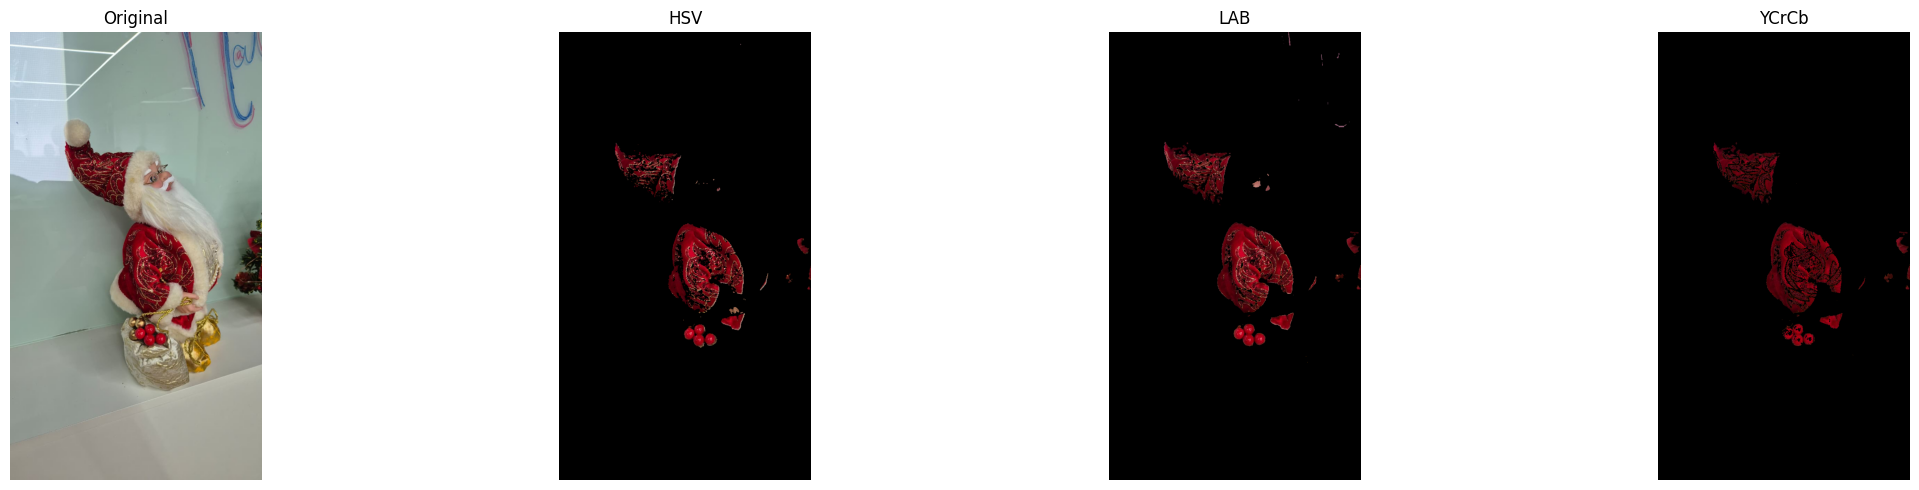

In [17]:
plt.figure(figsize=(24,5))

plt.subplot(1,4,1)
plt.imshow(img_rgb)
plt.title("Original")
plt.axis("off")

plt.subplot(1,4,2)
plt.imshow(result)
plt.title("HSV")
plt.axis("off")

plt.subplot(1,4,3)
plt.imshow(result_lab)
plt.title("LAB")
plt.axis("off")

plt.subplot(1,4,4)
plt.imshow(result_ycbcr)
plt.title("YCrCb")
plt.axis("off")

plt.tight_layout()
plt.show()


Preparação para K-means:
cada pixel vira um vetor (L, a, b) e é agrupado por similaridade de cor.


In [18]:
pixels = img_lab.reshape((-1, 3))
pixels = np.float32(pixels)


K = 5  # fundo + vermelho + outras cores

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER,
            100, 0.2)

_, labels, centers = cv2.kmeans(
    pixels,
    K,
    None,
    criteria,
    10,
    cv2.KMEANS_RANDOM_CENTERS
)


Identificação do vermelho:
no LAB, vermelho → valores altos no canal a.
Seleciona-se o cluster com maior valor de a.


In [19]:
centers = np.uint8(centers)

a_channel = centers[:, 1]  # canal "a"
red_cluster = np.argmax(a_channel)


Criação da máscara:
seleciona os pixels do cluster vermelho e reconstrói a máscara binária.


In [20]:
labels = labels.flatten()
mask_kmeans = np.zeros(labels.shape, dtype=np.uint8)
mask_kmeans[labels == red_cluster] = 255

mask_kmeans = mask_kmeans.reshape(img_lab.shape[:2])


Imagem quantizada:
cada pixel assume a cor do centro do seu cluster.


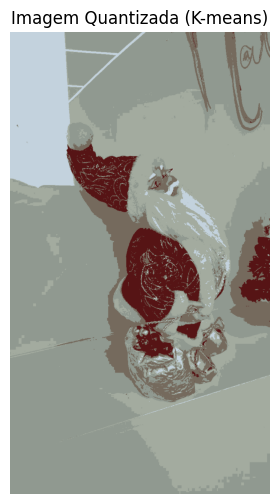

In [21]:
segmented = centers[labels]
segmented = segmented.reshape(img_lab.shape)

segmented_rgb = cv2.cvtColor(segmented, cv2.COLOR_LAB2RGB)

plt.figure(figsize=(6,6))
plt.imshow(segmented_rgb)
plt.title("Imagem Quantizada (K-means)")
plt.axis("off")
plt.show()

Aplicação da máscara K-means:
preserva a cor original apenas nos pixels do cluster vermelho.


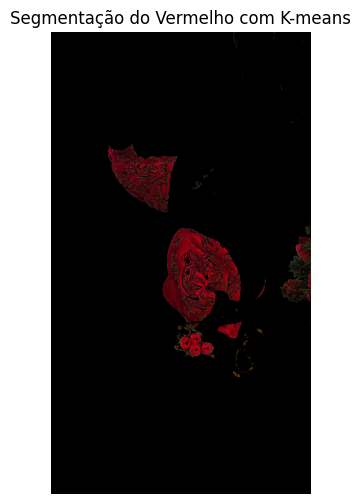

In [22]:
result_kmeans = cv2.bitwise_and(img_rgb, img_rgb, mask=mask_kmeans)

plt.figure(figsize=(6,6))
plt.imshow(result_kmeans)
plt.title("Segmentação do Vermelho com K-means")
plt.axis("off")
plt.show()


(np.float64(-0.5), np.float64(719.5), np.float64(1279.5), np.float64(-0.5))

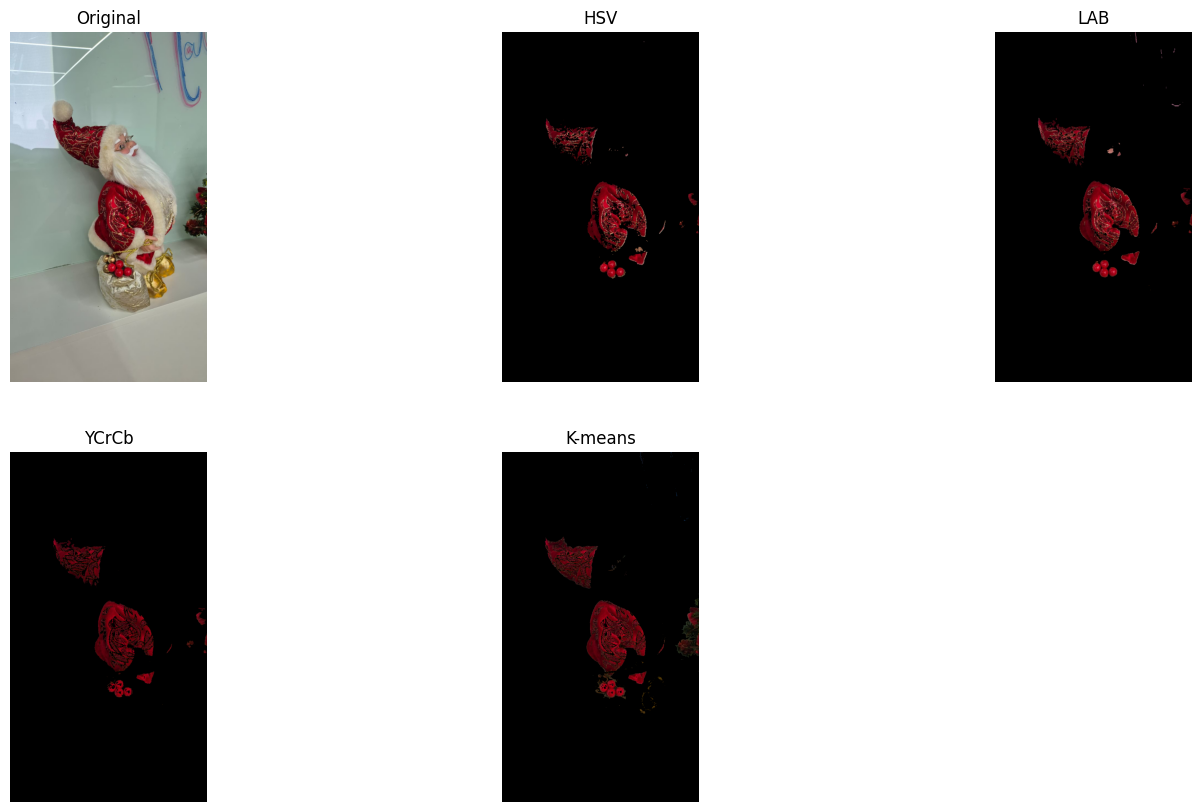

In [23]:
plt.figure(figsize=(18,10))


plt.subplot(2,3,1)
plt.imshow(img_rgb)
plt.title("Original")
plt.axis("off")

plt.subplot(2,3,2)
plt.imshow(result)
plt.title("HSV")
plt.axis("off")

plt.subplot(2,3,3)
plt.imshow(result_lab)
plt.title("LAB")
plt.axis("off")


plt.subplot(2,3,4)
plt.imshow(result_ycbcr)
plt.title("YCrCb")
plt.axis("off")

plt.subplot(2,3,5)
plt.imshow(result_kmeans)
plt.title("K-means")
plt.axis("off")


